# Modelo para Análisis de sentimientos

### Importando librerías

In [94]:
import pandas as pd

import spacy

import nltk
from nltk.corpus import stopwords
from nltk import bigrams, trigrams, ngrams, skipgrams
from collections import defaultdict
from string import punctuation

from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lordm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lordm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Funciones

In [267]:
def generador_tokens(text, remove_stopwords=False, lemmatize=False, remove_punctuation=False):

    # Tokenización
    tokens = word_tokenize(text)

    # Eliminar signos de puntuación
    if remove_punctuation:
        punctuations = list(punctuation)
        tokens = [word for word in tokens if word.isalnum() and word not in punctuations]

    # Eliminar stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('spanish'))
        tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    
    # Lematización
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

def generador_grama(df, n, k, remove_stopwords=False, lemmatize=False, remove_punctuation=False):
  gram_generate = defaultdict(int)

  # Procesando cada opinión
  for index, row in df.iterrows():
      opinion = row['Opinion']
      
      # Preprocesando el texto de la opinión y generador de tokens
      tokens = generador_tokens(opinion, remove_stopwords, lemmatize, remove_punctuation)
        
      # Generando n-gramas
      n_grams = ngrams(tokens, n)
      #n_grams = skipgrams(tokens, n, k)
        
      # Actualizando el puntaje de los n-gramas
      for gram in n_grams:
        gram_generate[gram] += 1
  
  return gram_generate

# Evaluación de un texto
# Regresa un score donde se suman las frecuencias de los n-gramas positivos y se restan las frecuencias de los n-gramas negativos
def evaluar_texto(texto, frec_positivos, frec_negativos, frec_palabras_title, n, k):
    score = 0
    
    # Preprocesando el texto de la opinión y generador de tokens
    tokens = generador_tokens(texto, remove_stopwords=True, lemmatize=False, remove_punctuation=True)
    
    # Conteo de n-gramas 
    for n_grama in ngrams(tokens, n):
    #for n_grama in skipgrams(tokens, n, k):
        score += (frec_positivos[n_grama]) * 0.95
        score -= (frec_negativos[n_grama]) * 0.95
        print(n_grama, "+", frec_positivos[n_grama], "-", frec_negativos[n_grama])   

        for palabra in n_grama:
            if palabra in frec_palabras_title:
                score += (frec_palabras_title[palabra]) *  0.05

    return score

def evaluar_texto_tile(texto, frec_positivos, frec_negativos, frec_palabras_title, n, k):
    score = 0
    
    # Preprocesando el texto de la opinión y generador de tokens
    tokens = generador_tokens(texto, remove_stopwords=True, lemmatize=False, remove_punctuation=True)
    
    for palabra in tokens:
        if palabra in frec_palabras_title:
            score += frec_palabras_title[palabra]

    return score


# Clasificación del score
def clasificar(score):

    if score >= 0:  #Positivo
        return 1
    else:
        return 0    #Negativo
    

# Clasificación del score
#def clasificar_remasterizado(df):
#    score = 0

#    for row in df.iterrow()
#    if (t['score_opinion'] * t['score_opinion']) >= (t['score_title'] * t['score_title']):
#        score = t['score_opinion']
#    else:
#        score = t['score_title']

#    if score >= 0:  #Positivo
#        return 1
#    else:
#        return 0    #Negativo

### Cargando conjuntos de entrenamiento y validación

In [119]:
train = pd.read_csv('../data/processed/train.csv', index_col=[0], parse_dates=['Date'], dayfirst=True)

val = pd.read_csv('../data/processed/val.csv', index_col=[0], parse_dates=['Date'], dayfirst=True)

### Separando por clase (Positivos y Negativos)

In [165]:
train_opiniones_positivas = train[train['Label'] == 1][['Title','Opinion']]

train_opiniones_negativas = train[train['Label'] == 0][['Title','Opinion']]

In [166]:
# Se sustituyen los valores nulos por un string vacío
train_opiniones_positivas['Title'] = train_opiniones_positivas['Title'].fillna('')
train_opiniones_positivas['Opinion'] = train_opiniones_positivas['Opinion'].fillna('')
train_opiniones_negativas['Title'] = train_opiniones_negativas['Title'].fillna('')
train_opiniones_negativas['Opinion'] = train_opiniones_negativas['Opinion'].fillna('')

In [167]:
train_opiniones_positivas

,Title,Opinion
1390,muy bueno,la verdad no me gustaron para nada las momias ...
2765,punto central,basilica muy bien conservada punto central en ...
3566,excelente vista panoramica,se puede ver toda la ciudad de guanajuato desd...
3317,museo dentro del cementerio,si no vas al museo no conoces guanajuato sorpr...
2834,distintivo de guanajuato e imperdible visitarlo,nos parecio interesante desde su estructura y ...
...,...,...
3401,lugar historico,pidan siempre les de la explicacion la persona...
3542,visita muy rapida,solo es como tradicion pasar por ese callejon ...
3176,majestuosa,tal vez una de las universidades mas bonitas d...
2174,un sitio peculiar,este es uno de los lugares que se tienen que v...


### Aplicando técnicas para el balanceo de clases

#### 1. Sobremuestreo de la clase minoritaria (Oversampling)

In [168]:
# Duplicar las reseñas de la clase minoritaria (negativos)
opiniones_negativas_duplicadas = train_opiniones_negativas.sample(n=len(train_opiniones_positivas) - len(train_opiniones_negativas), replace=True, random_state=42)

# Combinar el DataFrame original con las reseñas duplicadas
train_opiniones_negativas_balanceado = pd.concat([train_opiniones_negativas, opiniones_negativas_duplicadas])

print("Positivas: ", len(train_opiniones_positivas), " - Negativas: ", len(train_opiniones_negativas_balanceado))

Positivas:  2892  - Negativas:  2892


In [163]:
train_opiniones_negativas_balanceado

,Title,Opinion
763,punto turistico por excelencia,este es uno de los lugares que su visita es ob...
0,no es para recomendarse,las famosas momias de guanajuato el museo en s...
145,si vas es por ver arte y no precisamente de diego,debes venir a este lugar con la plena concienc...
298,acosadores,la vista no tiene comparacion pero hay muchos ...
152,visita,hay que planear la visita en domingo ya que ci...
...,...,...
230,gran variedad,los recuerdos o souvenirs son muy basicos para...
443,mercadeo a vapor,me gusto su entrada la cual es bella y hace cr...
128,solo la vista panoramica,la vista es increible pero el lugar deja mucho...
747,no abren,es un atractivo turistico la gente va en fecha...


#### 2. Submuestreo de la clase mayoritaria (Undersampling)

In [ ]:
# Realizar submuestreo de la clase mayoritaria para que tenga el mismo número de instancias que la clase minoritaria
#train_opiniones_positivas_balanceado = train_opiniones_positivas.sample(n=len(train_opiniones_negativas), random_state=42)
#train_opiniones_positivas_balanceado.shape


#### 3. Combinación oversampling + undersampling

In [ ]:
## Calcular número de reseñas que deberán tener ambos conjuntos
#diff = len(train_opiniones_positivas) - len(train_opiniones_negativas)
#n_muestras = int(diff / 2)

#train_opiniones_positivas_balanceado = train_opiniones_positivas.sample(n=len(train_opiniones_positivas)-n_muestras, random_state=42)
#print(train_opiniones_positivas_balanceado.shape)

## Duplicar las reseñas de la clase minoritaria (negativos)
#opiniones_negativas_duplicadas = train_opiniones_negativas.sample(n=n_muestras, replace=True, random_state=42)


## Combinar el DataFrame original con las reseñas duplicadas
#train_opiniones_negativas_balanceado = pd.concat([train_opiniones_negativas, opiniones_negativas_duplicadas])

#train_opiniones_negativas_balanceado.shape

In [217]:
token_title_positivo = defaultdict(int)

# Procesando cada opinión
for index, row in train_opiniones_positivas.iterrows():
    title = row['Title']
      
    # Preprocesando el texto de la opinión y generador de tokens
    tokens = generador_tokens(title, remove_stopwords=True, lemmatize=False, remove_punctuation=True)
        
    for token in tokens:
        token_title_positivo[token] += 1


token_title_negativo = defaultdict(int)

# Procesando cada opinión
for index, row in train_opiniones_negativas_balanceado.iterrows():
    title = row['Title']
      
    # Preprocesando el texto de la opinión y generador de tokens
    tokens = generador_tokens(title, remove_stopwords=True, lemmatize=False, remove_punctuation=True)
        
    for token in tokens:
        token_title_negativo[token] += 1

In [218]:
# Diccionario para almacenar la resta
frec_palabras_title = defaultdict(int)

# Realiza la resta de las claves comunes
for palabra in token_title_negativo.keys() & token_title_positivo.keys():
    frec_palabras_title[palabra] = token_title_positivo[palabra] - token_title_negativo[palabra]

# Imprimir el resultado
print(frec_palabras_title)

defaultdict(<class 'int'>, {'solo': -50, 'apto': -12, 'ubicacion': -2, 'monumental': -3, 'alta': -10, 'corazon': 16, 'noche': 5, 'cabeza': -8, 'visitas': -2, 'organizado': -8, 'espera': -13, 'puede': -4, 'romantico': 46, 'miedo': -2, 'afuera': 0, 'corto': 0, 'turistica': -4, 'pasado': 2, 'arte': 4, 'excelente': 118, 'estudiantinas': -4, 'demasiado': 1, 'entrada': -9, 'cualquier': -5, 'impresionables': -6, 'guias': -12, 'estrecho': -5, 'debemos': -5, 'gustan': -3, 'padre': 1, 'ser': -16, 'divertido': 2, 'hace': -2, 'puedes': 9, 'mejores': -3, 'vuelta': -4, 'parece': 0, 'mexico': 27, 'ninos': -12, 'totalmente': -8, 'imponentes': -6, 'punto': 8, 'plaza': -3, 'obra': -10, 'vale': -22, 'primera': -14, 'rompen': -3, 'imponente': 24, 'dejar': 9, 'van': -9, 'conocer': -8, 'must': -1, 'buena': -8, 'complemento': -4, 'casi': -9, 'variedad': -5, 'historico': 43, 'importante': 5, 'deberia': -3, 'dia': 3, 'pintoresca': -3, 'fachada': 1, 'simple': -3, 'majestuoso': 10, 'experiencia': 4, 'panoramica'

In [219]:
frec_title_positivo = defaultdict(int)
frec_title_negativo = defaultdict(int)

for index, row in train_opiniones_positivas.iterrows():
      title = row['Title']

      # Preprocesando el texto de la opinión y generador de tokens
      tokens = generador_tokens(title, remove_stopwords=True, lemmatize=False, remove_punctuation=True)
        
      for token in tokens:
            if token in frec_palabras_title:
                  frec_title_positivo[token] = (frec_palabras_title[token] * 1) if frec_palabras_title[token] >= 0 else 0

for index, row in train_opiniones_negativas_balanceado.iterrows():
      title = row['Title']

      # Preprocesando el texto de la opinión y generador de tokens
      tokens = generador_tokens(title, remove_stopwords=True, lemmatize=False, remove_punctuation=True)
        
      for token in tokens:
            if token in frec_palabras_title:
                  frec_title_negativo[token] = ((frec_palabras_title[token] * 1)) if frec_palabras_title[token] < 0 else 0
                  

In [220]:
# Diccionario para almacenar la resta
frec_palabras_title = defaultdict(int)

# Realiza la resta de las claves comunes
for palabra in frec_title_negativo.keys() & frec_title_positivo.keys():
    frec_palabras_title[palabra] = frec_title_positivo[palabra] + frec_title_negativo[palabra]

# Imprimir el resultado
print(frec_palabras_title)

defaultdict(<class 'int'>, {'apto': -12, 'solo': -50, 'ubicacion': -2, 'monumental': -3, 'alta': -10, 'corazon': 16, 'noche': 5, 'cabeza': -8, 'visitas': -2, 'organizado': -8, 'espera': -13, 'puede': -4, 'romantico': 46, 'miedo': -2, 'afuera': 0, 'corto': 0, 'turistica': -4, 'pasado': 2, 'arte': 4, 'excelente': 118, 'estudiantinas': -4, 'demasiado': 1, 'entrada': -9, 'cualquier': -5, 'impresionables': -6, 'guias': -12, 'estrecho': -5, 'debemos': -5, 'gustan': -3, 'padre': 1, 'ser': -16, 'divertido': 2, 'hace': -2, 'puedes': 9, 'mejores': -3, 'vuelta': -4, 'parece': 0, 'mexico': 27, 'ninos': -12, 'totalmente': -8, 'imponentes': -6, 'punto': 8, 'plaza': -3, 'obra': -10, 'vale': -22, 'primera': -14, 'rompen': -3, 'imponente': 24, 'dejar': 9, 'van': -9, 'conocer': -8, 'must': -1, 'buena': -8, 'complemento': -4, 'casi': -9, 'variedad': -5, 'historico': 43, 'importante': 5, 'deberia': -3, 'dia': 3, 'pintoresca': -3, 'fachada': 1, 'simple': -3, 'majestuoso': 10, 'experiencia': 4, 'panoramica'

In [173]:
for word in frec_palabras_title:
    if frec_palabras_title[word] < 0:
        print(word)

apto
solo
ubicacion
monumental
alta
cabeza
visitas
organizado
espera
puede
miedo
turistica
estudiantinas
entrada
cualquier
impresionables
guias
estrecho
debemos
gustan
ser
hace
mejores
vuelta
ninos
totalmente
imponentes
plaza
obra
vale
primera
rompen
van
conocer
must
buena
complemento
casi
variedad
deberia
pintoresca
simple
saturado
tranquilidad
tour
fanaticos
tradicion
cliche
viejo
unas
beso
visitalo
favor
pena
caro
dentro
pequeno
arboles
iluminacion
cosa
clasico
ido
momia
cansado
rincon
dejan
recuerdos
generos
macabro
parque
mejorable
visto
imposible
diferente
va
podria
mexicano
guia
escalofriante
estructura
mejorar
tomar
comer
personas
vez
curiosidad
especial
mercadeo
atraccion
mucha
triste
chica
gusta
conservada
emblematico
invaluable
enamorados
santa
muertos
rapido
paredes
ano
pies
souvenirs
interes
parte
morbo
subida
bueno
encuentro
pues
mal
cercania
leyenda
turistico
ve
varias
faltar
fotos
vas
sacar
mercado
tradicional
comida
escala
museo
entretenido
mundo
aburrido
darse
interes

### Entrenamiento

In [184]:
# Número de n-gramas
n = 2

# Número de tokens a saltar
k = 1

# Modelo de conteos de n_gramas
frec_positivos = defaultdict(int) 
frec_negativos = defaultdict(int) 

frec_positivos = generador_grama(train_opiniones_positivas, n, k, remove_stopwords=True, lemmatize=False,remove_punctuation=True)
frec_negativos = generador_grama(train_opiniones_negativas_balanceado, n, k, remove_stopwords=True, lemmatize=False,remove_punctuation=True)

### Evaluación

In [221]:
#texto = 'el edificio esta en excelentes condiciones y las muestras son buenas guanajuato es esencial para comprender la historia de mexico y tambien lo son los muros y cuartos de la alhondiga que conserva en el silencio de sus muros y salas llantos conspiraciones politicas y piezas que trazan la arqueologia de nuestro pasado el museo es interesante pero el viajero debe poner todo de su parte para prender y hacer del recorrido una experiencia atractiva el museo tiene un gran reo por delante para captar la atencion de todo tipo de visitantes sin embargo hay guias muy buenos en la sala de exposicion de pinturas de milagros hay una guia excepcional ella transformo mi visita fue genial'
texto = 'realismo magico'
evaluar_texto(texto, frec_positivos, frec_negativos, frec_palabras_title, n, k)

('realismo', 'magico') + 0 - 0


0.0

In [270]:
# Copia del conjunto de validación
df_val_opiniones = val.copy()


df_val_opiniones['Title'] = df_val_opiniones['Title'].fillna('')

df_val_opiniones['Score_Opinion'] = df_val_opiniones['Opinion'].apply(lambda x: evaluar_texto(x, frec_positivos, frec_negativos, frec_palabras_title, n, k))
df_val_opiniones['Score_Title'] = df_val_opiniones['Title'].apply(lambda x: evaluar_texto(x, frec_positivos, frec_negativos, frec_palabras_title, n, k))
df_val_opiniones['Score'] = df_val_opiniones['Score_Opinion'] + df_val_opiniones['Score_Title'] 
df_val_opiniones['Clasificación'] = df_val_opiniones['Score'].apply(clasificar)


('llegas', 'museo') + 0 - 0
('museo', 'parece') + 0 - 0
('parece', 'mas') + 0 - 8
('mas', 'terminal') + 0 - 0
('terminal', 'vieja') + 0 - 0
('vieja', 'autobuses') + 0 - 0
('autobuses', 'pueblo') + 0 - 0
('pueblo', 'mala') + 0 - 0
('mala', 'muerte') + 0 - 0
('muerte', 'museo') + 0 - 0
('museo', 'sabes') + 0 - 0
('sabes', 'experiencia') + 0 - 0
('experiencia', 'sera') + 0 - 0
('sera', 'buena') + 0 - 0
('buena', 'epoca') + 0 - 0
('epoca', 'vacacional') + 0 - 0
('vacacional', 'raro') + 0 - 0
('raro', 'tardar') + 0 - 0
('tardar', 'mas') + 0 - 0
('mas', 'horas') + 0 - 0
('horas', 'fila') + 2 - 3
('fila', 'entrar') + 5 - 6
('entrar', 'museo') + 4 - 10
('museo', 'consiste') + 0 - 0
('consiste', 'unas') + 0 - 0
('unas', 'salas') + 1 - 0
('salas', 'aproximadamente') + 1 - 0
('aproximadamente', 'mal') + 0 - 0
('mal', 'ventiladas') + 0 - 0
('ventiladas', 'pequenas') + 0 - 0
('pequenas', 'resulta') + 0 - 0
('resulta', 'dificil') + 0 - 0
('dificil', 'tan') + 0 - 0
('tan', 'solo') + 3 - 9
('solo', 'c

In [274]:
df_val_opiniones.head(40)

,Title,Opinion,Place,Gender,Age,Country,Date,Label,Lang,Score_Opinion,Score_Title,Score,Clasificación
577,decepcionante,desde que llegas y el museo parece mas una ter...,Museo de las Momias,Male,42,México,06/01/2015,0,es,-75.05,0.00,-75.05,0
4030,visita obligada,callejon de historia y de amor que algunos dic...,Callejón del Beso,Male,-1,México,2019,1,es,5.75,19.05,24.80,1
2390,un edificio emblematico,un edificio que vale a pena hacerle fotos desd...,Universidad de Guanajuato,Male,53,México,09/02/2016,1,es,42.30,-1.75,40.55,1
4290,lugar tipico,me encanto es muy divertido te toman foto te d...,Callejón del Beso,Female,29,México,01/10/2017,1,es,44.35,1.60,45.95,1
4380,visita obligada,visita obligada excelente vista panoramica de ...,Monumento Pípila,Female,17,México,31/08/2015,1,es,90.35,19.05,109.40,1
1116,precioso teatro,sin duda hay que visitar este teatro y aprecia...,Teatro Juárez,Female,38,México,27/03/2016,1,es,15.45,0.00,15.45,1
3599,paseo,es un lugar precioso con una vista inigualable...,Monumento Pípila,Female,39,Colombia,27/10/2017,1,es,131.00,0.00,131.00,1
1975,corto pero imperdible,recomendable por que alberga parte de la obra ...,Casa de Diego Rivera,Male,20,México,16/05/2015,1,es,-29.25,1.65,-27.60,0
784,historia,me impacto es una visita que te lleva a la his...,Monumento Pípila,Female,60,México,19/09/2017,1,es,62.25,0.00,62.25,1
3930,tiene una historia interesante,es un callejon muy pequeno pero tiene la histo...,Callejón del Beso,Female,24,México,16/09/2016,1,es,31.75,7.35,39.10,1


In [271]:
from sklearn.metrics import f1_score

f1_score = f1_score(df_val_opiniones['Label'], df_val_opiniones['Clasificación'])

print(f'F1 Score:', f1_score)

F1 Score: 0.8537666174298375


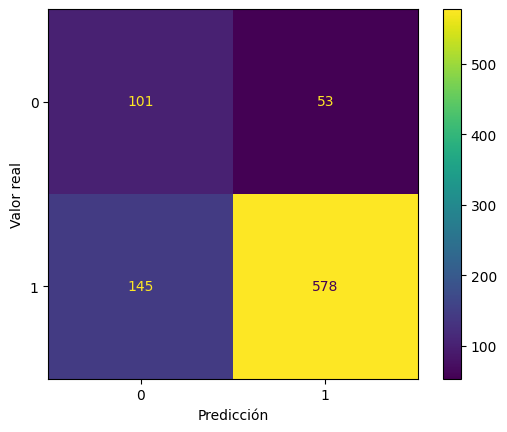

In [272]:
# Plot matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(df_val_opiniones['Label'], df_val_opiniones['Clasificación'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

In [12]:
print(classification_report(df_val_opiniones['Label'], df_val_opiniones['Clasificación']))

              precision    recall  f1-score   support

           0       0.37      0.59      0.46       154
           1       0.90      0.79      0.84       723

    accuracy                           0.75       877
   macro avg       0.64      0.69      0.65       877
weighted avg       0.81      0.75      0.77       877



In [13]:
df_val_opiniones['Clasificación'].value_counts()

Clasificación
1    633
0    244
Name: count, dtype: int64

In [14]:
# Falsos positivos
falsos_positivos = df_val_opiniones[(df_val_opiniones['Label'] == 0) & (df_val_opiniones['Clasificación'] == 1)][['Title', 'Opinion', 'Place', 'Label','Score', 'Clasificación']]
falsos_positivos.head()

,Title,Opinion,Place,Label,Score,Clasificación
27,es mas viejo que las momias,en condiciones mediocres demasiado personal pa...,Museo de las Momias,0,3,1
35,historia,escultura importante que se encuentra sobre un...,Monumento Pípila,0,10,1
569,realismo magico,hay una leyenda acerca de este lugar que me pa...,Callejón del Beso,0,34,1
617,excelentes fotos panoramicas,este lugar es perfecto para tomar fotografias ...,Monumento Pípila,0,83,1
21,demasiado calor dentro de la estatua,no disfruto ir al pipila pero siendo de guanaj...,Monumento Pípila,0,9,1


In [15]:
falsos_positivos['Score'].value_counts()

Score
0      5
3      4
5      4
7      4
8      3
4      3
13     3
2      3
18     3
20     2
9      2
62     2
12     2
14     2
91     1
25     1
28     1
36     1
63     1
21     1
49     1
1      1
105    1
26     1
34     1
57     1
47     1
23     1
10     1
83     1
31     1
11     1
46     1
22     1
6      1
Name: count, dtype: int64

In [16]:
# Falsos negativos
falsos_negativos = df_val_opiniones[(df_val_opiniones['Label'] == 1) & (df_val_opiniones['Clasificación'] == 0)][['Title', 'Opinion', 'Place', 'Label','Score', 'Clasificación']]
falsos_negativos.tail()

,Title,Opinion,Place,Label,Score,Clasificación
1407,interesante lugar,un museo muy interesante y diferente recomiend...,Museo de las Momias,1,-14,0
2578,templo con enorme belleza,me encanto su interior lleno de hermosura tant...,Basilica Colegiata,1,-21,0
3341,es una experiencia diferente,visite el museo de las momias con mi esposa y ...,Museo de las Momias,1,-75,0
834,estremecedor,perdi la cuenta de las veces que mi padre me l...,Museo de las Momias,1,-2,0
2838,interesante cuando es primera vez,es un buen lugar para conocer sobre museo y ma...,Museo de las Momias,1,-49,0


In [17]:
falsos_negativos['Score'].value_counts()

Score
-4      12
-2      11
-1       8
-3       8
-7       6
-5       6
-6       6
-14      5
-12      5
-11      5
-13      5
-9       5
-27      4
-16      4
-22      4
-10      3
-24      3
-20      3
-54      3
-8       3
-18      3
-15      3
-62      2
-38      2
-44      2
-28      2
-30      2
-23      2
-56      2
-51      1
-75      1
-21      1
-34      1
-46      1
-129     1
-58      1
-26      1
-103     1
-31      1
-37      1
-66      1
-25      1
-91      1
-19      1
-40      1
-63      1
-39      1
-41      1
-74      1
-55      1
-81      1
-32      1
-49      1
Name: count, dtype: int64

### Prueba

In [220]:
## Cargar el conjunto de prueba
#test = pd.read_csv('../data/raw/test.csv', index_col=[0], parse_dates=['Date'], dayfirst=True)

## Aplicar el modelo a las reseñas de prueba
#test['Score'] = test['Opinion'].apply(lambda x: evaluar_texto(x, frec_positivos, frec_negativos, n))
#test['Clasificación'] = test['Score'].apply(clasificar)

## F1 Score
#f1_score = f1_score(test['Label'], test['Clasificación'])
#print(f'F1 Score:', f1_score)

## Matriz de confusión
#cm = confusion_matrix(test['Label'], test['Clasificación'])
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot()
#plt.xlabel('Predicción')
#plt.ylabel('Valor real')
#plt.show()

## Classification report
#print(classification_report(test['Label'], test['Clasificación']))